In [20]:
import os
import shutil
import random
import logging
import time
import json
from tempfile import TemporaryDirectory
from PIL import Image
from sklearn.metrics import f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import RandAugment

import torchvision
from torchvision import models, transforms

# Configurations
cudnn.benchmark = True
plt.ion()  # interactive mode

# Logging Configuration
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

# Set random seed for reproducibility
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
generator = torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

%set_env CUBLAS_WORKSPACE_CONFIG=:4096:8

Random Seed:  999
env: CUBLAS_WORKSPACE_CONFIG=:4096:8


## Preparing a Balanced Subset of the Dataset

To speed up training while maintaining representativeness, we create a smaller, balanced dataset from our large collection (30K real, 90K fake images). We randomly sample 900 real and 900 fake images, then split them into 80% training and 20% validation sets.

The images are organized into resized_data/ for easy use with PyTorch’s ImageFolder:
```
resized_data/
├── train/
│   ├── real/   # 720 images
│   ├── fake/   # 720 images
├── val/
│   ├── real/   # 180 images
│   ├── fake/   # 180 images
```

In [2]:
# Base data path
BASE_DATA_DIR = "data"
RESIZED_DATA_DIR = "resized_data"

# Directories for real and fake images
REAL_DIR = os.path.join(BASE_DATA_DIR, "wiki")  # Path to real images
FAKE_DIRS = ["inpainting", "insight", "text2img"]  # Directories for fake images

TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15
assert(TRAIN_SPLIT + VAL_SPLIT + TEST_SPLIT == 1)

# Number of desired images
num_real_images = 30000
num_fake_images_per_folder = 30000

def create_directories():
    """Creates necessary directories for train and validation sets, removing old data first."""
    for category in ['train', 'val', 'test']:
        for subdir in ['real', 'fake']:
            dir_path = os.path.join(RESIZED_DATA_DIR, category, subdir)

            # Remove all existing files to prevent dataset accumulation
            if os.path.exists(dir_path):
                shutil.rmtree(dir_path)

            os.makedirs(dir_path, exist_ok=False)

def get_image_paths(directory):
    """Returns a list of image file paths within a directory structure."""
    image_paths = []
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):
            image_paths.extend(
                [
                    os.path.join(subdir_path, file)
                    for file in os.listdir(subdir_path)
                    if os.path.isfile(os.path.join(subdir_path, file))
                ]
            )
    return image_paths

def split_and_copy_images(image_paths, category):
    """Splits images into training, validation and test sets and copies them accordingly."""
    train, val, test = random_split(image_paths, [TRAIN_SPLIT, VAL_SPLIT, TEST_SPLIT], generator)
    def save_images(image_paths, destination):
        for image_path in image_paths:
            # Turns out images can have the same name, so we add a timestamp to the filename
            target_path = os.path.join(RESIZED_DATA_DIR, destination, category, str(time.time()) + os.path.basename(image_path))
            shutil.copy(image_path, target_path)
    save_images(train, 'train')
    save_images(val, 'val')
    save_images(test, 'test')

# Function to split images into 'train' and 'val'
def organize_data():
    # Create destination directories
    create_directories()

    # Handle real images
    real_images = get_image_paths(REAL_DIR)
    # Random sampling of real images
    sampled_real_images = random.sample(real_images, num_real_images)
    logging.info(f"Sampled {len(sampled_real_images)} real images.")

    # Split into train, val, test and copy to destination
    split_and_copy_images(sampled_real_images, 'real')

    # Handle fake images and random sampling
    sampled_fake_images = {
        fake_dir: random.sample(
            get_image_paths(os.path.join(BASE_DATA_DIR, fake_dir)),
            num_fake_images_per_folder,
        )
        for fake_dir in FAKE_DIRS
    }

    total_sampled_fake_images = sum(len(imgs) for imgs in sampled_fake_images.values())
    logging.info(f"Sampled {total_sampled_fake_images} fake images.")

    # Split into train, val, test and copy to destination
    for dir, sampled_images in sampled_fake_images.items():
        split_and_copy_images(sampled_images, 'fake')

    logging.info("Data organized successfully.")

organize_data()

2025-03-20 08:18:49,956 - INFO - Sampled 30000 real images.
2025-03-20 08:18:56,611 - INFO - Sampled 90000 fake images.
2025-03-20 08:19:11,779 - INFO - Data organized successfully.


## Loading and Preprocessing the Dataset

We now load the resized dataset and apply appropriate transformations for training and validation:

- **Training data**: Includes random cropping and horizontal flipping for augmentation, helping the model generalize better.
- **Validation data**: Only resized and centered to maintain consistency.
- **Normalization**: Standardizes pixel values using ImageNet’s mean and standard deviation.

## Transforms
Different model architectures require different transforms. For example, the image size to feed to a network may vary depending on the architecture.

### Augmentation
Some architectures may benefit more from certain data augmentation techniques than others, so we need to choose data augmentation methods carefully for each architecture.

In [3]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation

# Also accessible with models.ResNet18_Weights.transforms()
resnet_basic_transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)
resnet_augmentation_transform = transforms.Compose(
    [
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip horizontally
        transforms.RandomRotation(degrees=15),  # Rotate up to 15 degrees
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color changes
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)
# resnet_augmentation_transform_v2 = transforms.Compose( # similar to efficient net's augmentation (for comparison)
#     [
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip horizontally
#         RandAugment(),  # applies some transforms (randomly chosen)
#         transforms.ToTensor(),
#         transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
#     ]
# )

efficient_net_basic_transform = transforms.Compose([
    transforms.Resize(384),
    transforms.CenterCrop(384),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])
efficient_net_augmentation_transform = transforms.Compose([
    transforms.RandomResizedCrop(384),
    transforms.RandomHorizontalFlip(p=0.5),
    RandAugment(),  # applies some transforms (randomly chosen)
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

vit_basic_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])
vit_augmentation_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

models_tranforms_dict = {
    "resnet": {
        "train": resnet_augmentation_transform,
        "val": resnet_basic_transform,
        "test": resnet_basic_transform,
    },
    "efficient_net": {
        "train": efficient_net_augmentation_transform,
        "val": efficient_net_basic_transform,
        "test": efficient_net_basic_transform,
    },
    "vit": {
        "train": vit_augmentation_transform,
        "val": vit_basic_transform,
        "test": vit_basic_transform,
    },
}

In [5]:
# Now pointing to the resized data folder
data_dir = RESIZED_DATA_DIR
SPLITS = ["train", "val", "test"]

def get_dataset(transform):
    return {
        x: torchvision.datasets.ImageFolder(os.path.join(data_dir, x), transform[x])
        for x in SPLITS
    }

datasets = {
    "no_augmentation": {
        model: get_dataset(transforms)
        for model, transforms in models_tranforms_dict.items()
    },
    "augmentation": {
        model: get_dataset(transforms)
        for model, transforms in models_tranforms_dict.items()
    },
}
batch_sizes = { # CUDA out of memory error if batch size is too large
    "resnet": 32,
    "efficient_net": 16,
    "vit": 32,
}
dataloaders = {
    has_augmentation: {
        model: {
            x: DataLoader(dataset[x], batch_size=batch_sizes[model], shuffle=(x == "train"), num_workers=4)
            for x in SPLITS
        }
        for model, dataset in model_datasets.items()
    }
    for has_augmentation, model_datasets in datasets.items()
}
default_dataset = datasets["augmentation"]["resnet"]
default_dataloader = dataloaders["augmentation"]["resnet"]

# Get the size of each split (same for both without and with augmentation)
dataset_sizes = {x: len(default_dataset[x]) for x in SPLITS}
# Get the class names (same for both without and with augmentation)
class_names = default_dataset["train"].classes

In [6]:
dataset_sizes

{'train': 84000, 'val': 18000, 'test': 18000}

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [159]:
def calculate_class_weights(dataset):
    # Get the class counts
    class_counts = [0] * len(dataset.classes)
    for _, label in dataset:
        class_counts[label] += 1

    # Calculate weights (inversely proportional to class frequency)
    total_samples = sum(class_counts)
    class_weights = [total_samples / (len(class_counts) * count) for count in class_counts]

    # Convert to tensor
    weights = torch.FloatTensor(class_weights)
    return weights

# Calculate weights from training dataset (for later to use weighted cross-entropy) 
# Equivalent for data augmentation and without it
class_weights = calculate_class_weights(default_dataset["train"])
print(f"Class weights: {class_weights}")

Class weights: tensor([0.6667, 2.0000])


## Visualizing a Batch of Training Images

Before training, we visualize a batch of images from our training dataset to confirm correct loading and transformations.

- The imshow function denormalizes and displays images in a grid.
- A batch of images is retrieved from the training dataloader.
- Labels are mapped to class names and displayed as titles.

This helps verify data integrity and preprocessing before model training.

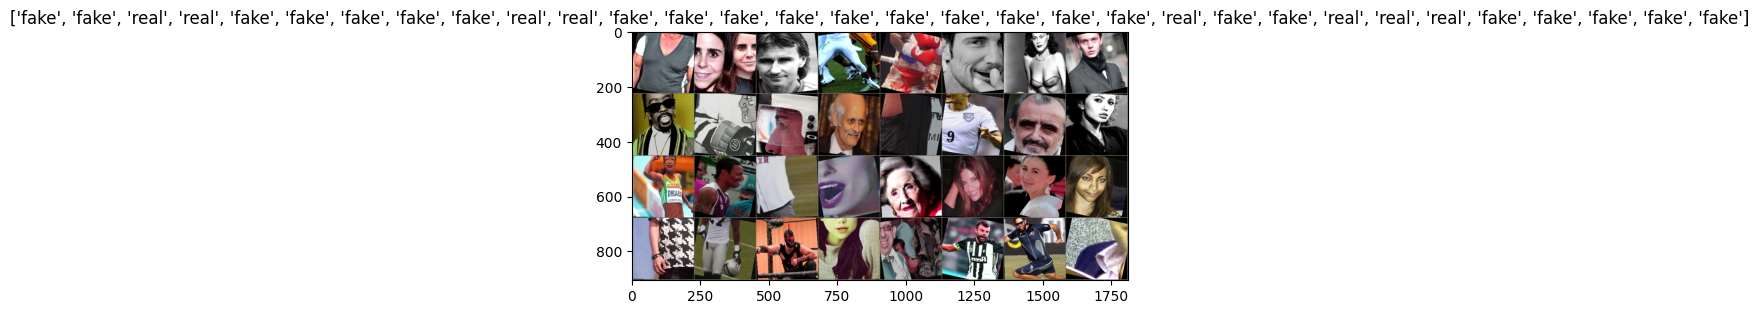

In [160]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(IMAGENET_MEAN)
    std = np.array(IMAGENET_STD)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(default_dataloader["train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the Model

This function trains a deep learning model using supervised learning with PyTorch. Key steps:

- Alternates between training (updating weights) and validation (evaluating performance).
- Uses cross-entropy loss and optimizes with gradient descent.
- Tracks the best validation accuracy, saving model parameters for later use.
- Implements a learning rate scheduler for better convergence.

After training, the model is restored to its best-performing state.

In [8]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25, verbose=True):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

        torch.save(model.state_dict(), best_model_params_path)
        best_f1 = 0.0

        # Store loss, accuracy and f1 values
        history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": [], 
                  "train_f1": [], "val_f1": []}

        for epoch in range(num_epochs):
            if verbose:
                print(f"Epoch {epoch}/{num_epochs - 1}")
                print("-" * 10)

            # Each epoch has a training and validation phase
            for phase in ["train", "val"]:
                if phase == "train":
                    model.train()  # Set model to training mode
                else:
                    model.eval()  # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0
                all_preds = []
                all_labels = []
                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == "train"):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == "train":
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                    # Collect predictions and labels for F1 score
                    all_preds.extend(preds.tolist())
                    all_labels.extend(labels.tolist())

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                if phase == "train" and scheduler is not None:
                    if type(scheduler) is lr_scheduler.ReduceLROnPlateau:
                        scheduler.step(epoch_loss)
                    else:
                        scheduler.step()

                # Convert lists to numpy arrays for sklearn
                all_preds = np.array(all_preds)
                all_labels = np.array(all_labels)

                # Calculate F1 score (using weighted average due to class imbalance)
                epoch_f1 = f1_score(all_labels, all_preds, average='weighted')

                # Store metrics in history
                history[f"{phase}_loss"].append(epoch_loss)
                history[f"{phase}_acc"].append(epoch_acc.item())
                history[f"{phase}_f1"].append(epoch_f1)

                if verbose:
                    print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f}")

                # deep copy the model (using F1 score as the criterion for best model)
                if phase == "val" and epoch_f1 > best_f1:
                    best_f1 = epoch_f1
                    torch.save(model.state_dict(), best_model_params_path)

            if verbose:
                print()

        time_elapsed = time.time() - since
        print(
            f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s"
        )
        if verbose:
            print(f"Best val F1: {best_f1:4f}")

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, history

## Evaluating Model Predictions

This function visualizes the model’s predictions on validation data:

- The model switches to evaluation mode to disable weight updates.
- Images and predicted labels are displayed alongside ground truth data.
- Helps assess model performance qualitatively by identifying correct and incorrect classifications.

This provides an intuitive check on how well the model generalizes to unseen data.

In [162]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(default_dataloader["val"]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title(f"predicted: {class_names[preds[j]]}")
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Defining and Optimizing the Model

In this step, we initialize a ResNet-18 model pre-trained on ImageNet (IMAGENET1K_V1) and adapt it for our binary classification task (real vs. fake images). The final fully connected (fc) layer is replaced with a new linear layer that outputs two classes.

We define:
- Loss Function: CrossEntropyLoss, commonly used for classification tasks.
- Optimizer: Stochastic Gradient Descent (SGD) with momentum (0.9) to improve convergence.
- Learning Rate Scheduler: The learning rate decays by a factor of 0.1 every 7 epochs to enhance model stability during training.

In [163]:
model_base = models.resnet18()
num_ftrs = model_base.fc.in_features

# Here the size of each output sample is set to 2.
model_base.fc = nn.Linear(num_ftrs, 2)

model_base = model_base.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_base = optim.SGD(model_base.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_base, step_size=7, gamma=0.1)

In [164]:
model_base, epoch_results_base = train_model(
    model_base, dataloaders["no_augmentation"]["resnet"], criterion, optimizer_base, exp_lr_scheduler, num_epochs=15
)

Epoch 0/14
----------
train Loss: 0.5596 Acc: 0.7457 F1: 0.6518
val Loss: 0.5267 Acc: 0.7500 F1: 0.6437

Epoch 1/14
----------
train Loss: 0.5444 Acc: 0.7456 F1: 0.6549
val Loss: 0.5086 Acc: 0.7486 F1: 0.6528

Epoch 2/14
----------
train Loss: 0.5355 Acc: 0.7455 F1: 0.6609
val Loss: 0.6118 Acc: 0.7508 F1: 0.6472

Epoch 3/14
----------
train Loss: 0.5290 Acc: 0.7472 F1: 0.6691
val Loss: 0.5035 Acc: 0.7529 F1: 0.6702

Epoch 4/14
----------
train Loss: 0.5186 Acc: 0.7502 F1: 0.6829
val Loss: 0.5189 Acc: 0.7519 F1: 0.6691

Epoch 5/14
----------
train Loss: 0.5097 Acc: 0.7564 F1: 0.7009
val Loss: 0.7825 Acc: 0.7523 F1: 0.6533

Epoch 6/14
----------
train Loss: 0.4995 Acc: 0.7635 F1: 0.7188
val Loss: 0.6012 Acc: 0.7548 F1: 0.6607

Epoch 7/14
----------
train Loss: 0.4688 Acc: 0.7856 F1: 0.7512
val Loss: 0.4569 Acc: 0.7900 F1: 0.7485

Epoch 8/14
----------
train Loss: 0.4613 Acc: 0.7890 F1: 0.7588
val Loss: 0.4427 Acc: 0.7990 F1: 0.7656

Epoch 9/14
----------
train Loss: 0.4576 Acc: 0.7934 F1

## Training the Model

Now, we train our fine-tuned ResNet-18 model using the previously defined optimizer, loss function, and learning rate scheduler. The model will adjust its weights based on our dataset.

Note: In the original tutorial, the model is trained for 25 epochs, but since we are using more images than the tutorial and training on a CPU, I set it to just 1 epoch to keep runtime around 12 minutes.

## Feature Extraction with ResNet-18

Instead of fine-tuning all ResNet-18 layers, we freeze the pre-trained weights (requires_grad = False) and only train the final fully connected layer for binary classification. This approach, known as feature extraction, is useful when we have a smaller dataset and want to leverage pre-trained features.

- Only the final layer is optimized, making training more efficient.
- We still use SGD with momentum and a learning rate scheduler to optimize training.

This method ensures we benefit from ResNet’s powerful pre-trained features while reducing the computational cost of training. 

In [165]:
model_conv = torchvision.models.resnet18(weights="IMAGENET1K_V1")
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [166]:
model_conv, epoch_results_conv = train_model(
    model_conv, dataloaders["no_augmentation"]["resnet"], criterion, optimizer_conv, exp_lr_scheduler, num_epochs=15
)

Epoch 0/14
----------
train Loss: 0.5119 Acc: 0.7581 F1: 0.7180
val Loss: 0.5095 Acc: 0.7523 F1: 0.7501

Epoch 1/14
----------
train Loss: 0.5026 Acc: 0.7628 F1: 0.7289
val Loss: 0.5335 Acc: 0.7301 F1: 0.7362

Epoch 2/14
----------
train Loss: 0.5018 Acc: 0.7635 F1: 0.7321
val Loss: 0.4923 Acc: 0.7652 F1: 0.7486

Epoch 3/14
----------
train Loss: 0.5017 Acc: 0.7633 F1: 0.7315
val Loss: 0.5511 Acc: 0.7607 F1: 0.6807

Epoch 4/14
----------
train Loss: 0.5024 Acc: 0.7636 F1: 0.7318
val Loss: 0.5095 Acc: 0.7477 F1: 0.7449

Epoch 5/14
----------
train Loss: 0.4998 Acc: 0.7652 F1: 0.7335
val Loss: 0.5358 Acc: 0.7276 F1: 0.7366

Epoch 6/14
----------
train Loss: 0.5064 Acc: 0.7620 F1: 0.7301
val Loss: 0.5032 Acc: 0.7539 F1: 0.7486

Epoch 7/14
----------
train Loss: 0.4861 Acc: 0.7717 F1: 0.7361
val Loss: 0.4814 Acc: 0.7751 F1: 0.7445

Epoch 8/14
----------
train Loss: 0.4866 Acc: 0.7720 F1: 0.7358
val Loss: 0.4812 Acc: 0.7752 F1: 0.7502

Epoch 9/14
----------
train Loss: 0.4840 Acc: 0.7722 F1

In [167]:
model_resnet_no_augm_ft = models.resnet18(weights="IMAGENET1K_V1")
num_ftrs = model_resnet_no_augm_ft.fc.in_features

# Here the size of each output sample is set to 2.
model_resnet_no_augm_ft.fc = nn.Linear(num_ftrs, 2)

model_resnet_no_augm_ft = model_resnet_no_augm_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_resnet_no_augm_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [168]:
model_resnet_no_augm_ft, epoch_results_ft = train_model(
    model_resnet_no_augm_ft, dataloaders["no_augmentation"]["resnet"], criterion, optimizer_ft, exp_lr_scheduler, num_epochs=15
)

Epoch 0/14
----------
train Loss: 0.4262 Acc: 0.8048 F1: 0.7899
val Loss: 0.3150 Acc: 0.8608 F1: 0.8496

Epoch 1/14
----------
train Loss: 0.3537 Acc: 0.8420 F1: 0.8348
val Loss: 0.2518 Acc: 0.8924 F1: 0.8919

Epoch 2/14
----------
train Loss: 0.3198 Acc: 0.8571 F1: 0.8522
val Loss: 0.2558 Acc: 0.8888 F1: 0.8810

Epoch 3/14
----------
train Loss: 0.3004 Acc: 0.8665 F1: 0.8624
val Loss: 0.2327 Acc: 0.9016 F1: 0.8973

Epoch 4/14
----------
train Loss: 0.2870 Acc: 0.8729 F1: 0.8695
val Loss: 0.2121 Acc: 0.9082 F1: 0.9036

Epoch 5/14
----------
train Loss: 0.2767 Acc: 0.8791 F1: 0.8762
val Loss: 0.2262 Acc: 0.9026 F1: 0.9019

Epoch 6/14
----------
train Loss: 0.2664 Acc: 0.8839 F1: 0.8813
val Loss: 0.2290 Acc: 0.8997 F1: 0.9016

Epoch 7/14
----------
train Loss: 0.2357 Acc: 0.8972 F1: 0.8952
val Loss: 0.1651 Acc: 0.9303 F1: 0.9300

Epoch 8/14
----------
train Loss: 0.2278 Acc: 0.9013 F1: 0.8998
val Loss: 0.1610 Acc: 0.9328 F1: 0.9320

Epoch 9/14
----------
train Loss: 0.2212 Acc: 0.9052 F1

## Visualizing Model Predictions

This function allows us to visualize the model’s prediction for a given image. It follows these steps:

- Loads the image and applies the same transformations used during validation.
- Converts the image into a format suitable for the model (unsqueeze(0) to add batch dimension).
- Disables gradient computation (torch.no_grad()) for efficient inference.
- Predicts the class and displays the image with its predicted label.

This function helps us qualitatively evaluate the model’s performance by seeing its predictions on real examples.

In [169]:
def visualize_model_predictions(model, img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = resnet_basic_transform(img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2, 2, 1)
        ax.axis("off")
        ax.set_title(f"Predicted: {class_names[preds[0]]}")
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

## Running the Visualization on a Sample Image

Here, we test our trained feature extraction model (model_conv) by passing a real image from the validation set. The model's prediction is displayed alongside the image.

Note: Ensure that the input image is not grayscale. The function expects an RGB image (3 channels), and passing a single-channel grayscale image may lead to errors or unexpected behavior.

In [170]:
# visualize_model_predictions(
#     model_conv, img_path="resized_data/val/fake/50745_1941-10-13_2011.jpg"
# )

plt.ioff()
plt.show()

## Plotting Classification Performance

In [9]:
def plot_training_history(history, title_label=""):
    if title_label != "":
        title_label = f": {title_label}"
    epochs = range(len(history["train_loss"]))

    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    plt.title(f"Training & Validation Loss{title_label}")
    plt.legend()

    # F1 Plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_f1"], label="Train F1")
    plt.plot(epochs, history["val_f1"], label="Validation F1")
    plt.xlabel("Epochs")
    plt.ylabel("F1 Score")
    plt.title(f"Training & Validation F1 Score{title_label}")
    plt.legend()


    plt.show()

In [10]:
def test_model(model, test_dataloader, verbose=True):
    """
    Evaluates the model on the test dataset and returns accuracy and F1 score.
    
    Args:
        model (torch.nn.Module): Trained PyTorch model.
    Returns:
        dict: A dictionary containing accuracy and F1 score.
    """
    model.eval()  # Set model to evaluation mode
    running_corrects = 0
    all_preds = []
    all_labels = []
    dataloader = test_dataloader

    with torch.no_grad():  # No need to track gradients during evaluation
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.tolist())

    # Compute accuracy
    dataset_size = len(dataloader.dataset)
    accuracy = running_corrects.double() / dataset_size

    # Compute F1-score
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    f1 = f1_score(np.array(all_labels), np.array(all_preds), average='weighted')

    if verbose:
        print(f"Test Accuracy: {accuracy:.4f}, Test F1 Score: {f1:.4f}")

    return {"acc": accuracy.item(), "f1_score": f1, "labels": all_labels, "preds": all_preds}

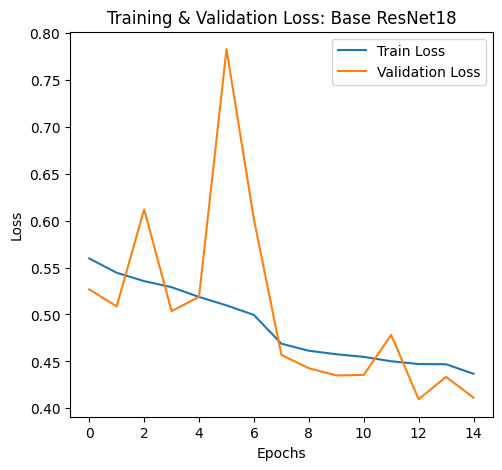

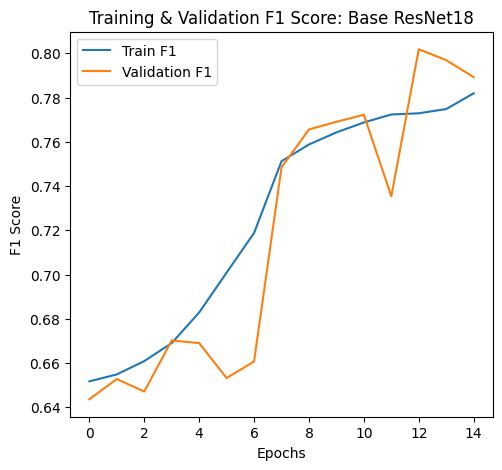

In [173]:
plot_training_history(epoch_results_base, "Base ResNet18")

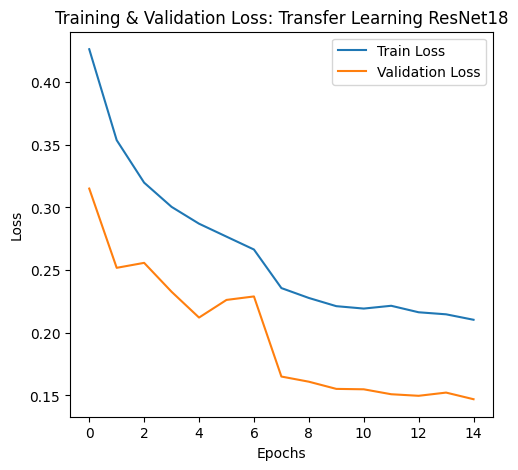

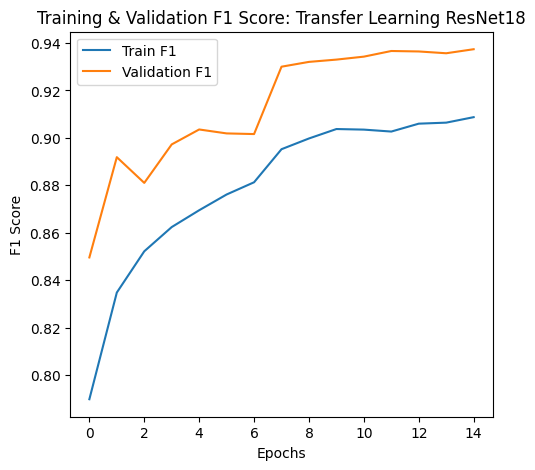

In [174]:
plot_training_history(epoch_results_ft, "Transfer Learning ResNet18")

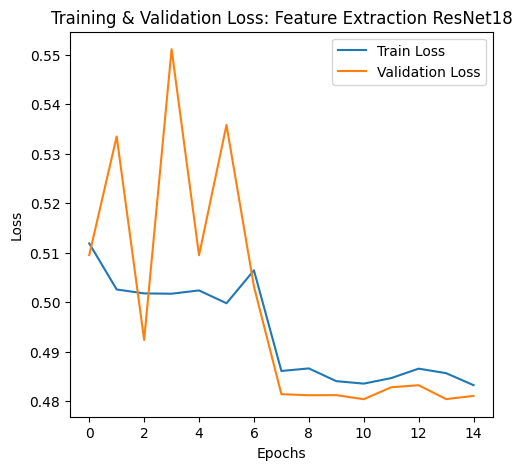

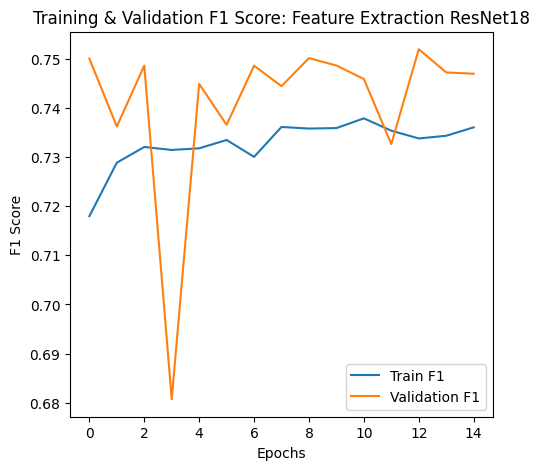

In [175]:
plot_training_history(epoch_results_conv, "Feature Extraction ResNet18")

In [176]:
model_ft = models.resnet18(weights="IMAGENET1K_V1")
num_ftrs = model_ft.fc.in_features

model_ft_data_augmented = models.resnet18(weights="IMAGENET1K_V1")
num_ftrs = model_ft_data_augmented.fc.in_features

model_ft_data_augmented.fc = nn.Linear(num_ftrs, 2)

model_ft_data_augmented = model_ft_data_augmented.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft_augmented = optim.SGD(model_ft_data_augmented.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_augmented, step_size=7, gamma=0.1)

model_ft_augmented, epoch_results_ft_augmented = train_model(
    model_ft_data_augmented, dataloaders["augmentation"]["resnet"], criterion, optimizer_ft_augmented, exp_lr_scheduler, num_epochs=15
)

Epoch 0/14
----------
train Loss: 0.4210 Acc: 0.8072 F1: 0.7925
val Loss: 0.3030 Acc: 0.8648 F1: 0.8640

Epoch 1/14
----------
train Loss: 0.3528 Acc: 0.8418 F1: 0.8345
val Loss: 0.2621 Acc: 0.8841 F1: 0.8825

Epoch 2/14
----------
train Loss: 0.3228 Acc: 0.8554 F1: 0.8502
val Loss: 0.2331 Acc: 0.9002 F1: 0.8990

Epoch 3/14
----------
train Loss: 0.3029 Acc: 0.8652 F1: 0.8611
val Loss: 0.2725 Acc: 0.8896 F1: 0.8803

Epoch 4/14
----------
train Loss: 0.2879 Acc: 0.8745 F1: 0.8710
val Loss: 0.2385 Acc: 0.8927 F1: 0.8947

Epoch 5/14
----------
train Loss: 0.2768 Acc: 0.8778 F1: 0.8748
val Loss: 0.2038 Acc: 0.9145 F1: 0.9124

Epoch 6/14
----------
train Loss: 0.2687 Acc: 0.8824 F1: 0.8797
val Loss: 0.1856 Acc: 0.9207 F1: 0.9190

Epoch 7/14
----------
train Loss: 0.2359 Acc: 0.8976 F1: 0.8957
val Loss: 0.1652 Acc: 0.9301 F1: 0.9293

Epoch 8/14
----------
train Loss: 0.2285 Acc: 0.9003 F1: 0.8987
val Loss: 0.1610 Acc: 0.9328 F1: 0.9324

Epoch 9/14
----------
train Loss: 0.2262 Acc: 0.9018 F1

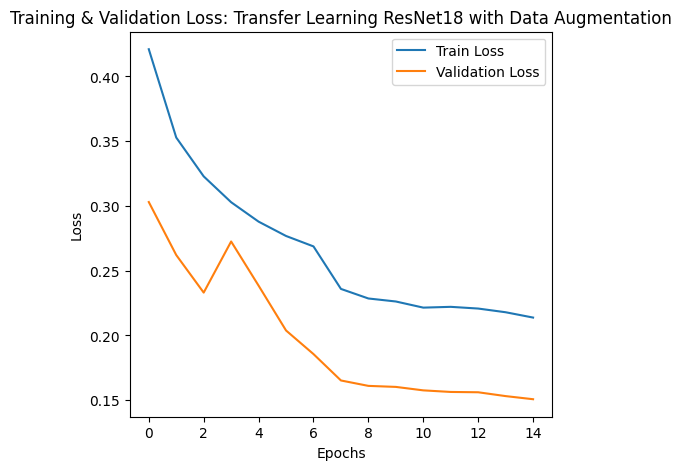

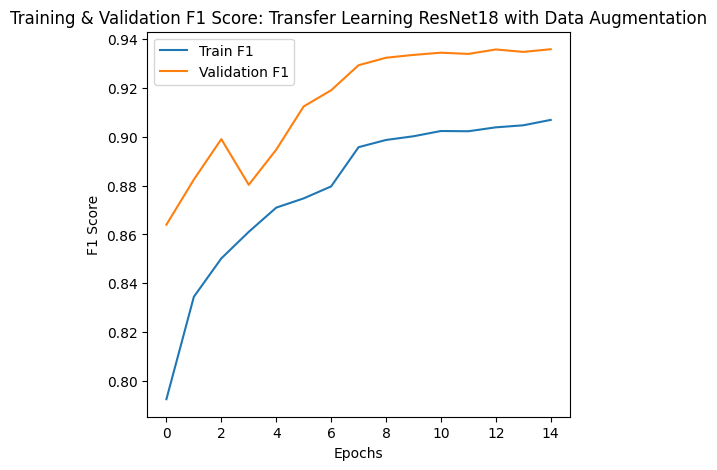

In [177]:
plot_training_history(epoch_results_ft_augmented, "Transfer Learning ResNet18 with Data Augmentation")

#### Improve learning rate decay and attempt to reduce training instability
- Use Adam optimizer
- Use different learning rates
- Use a different learning rate scheduler

In [178]:
def get_plot_location(filename):
    return os.path.join("plots", filename)

def plot_hyperparameter_results(results, model_name):
    """
    Plot the results of hyperparameter tuning
    
    Args:
        results: List of result dictionaries from hyperparameter tuning
    """
    # Sort results by validation F1 score
    sorted_results = sorted(results, key=lambda x: x['val_f1'], reverse=True)

    # 1. Bar plot comparing all configurations by F1 score
    plt.figure(figsize=(14, 8))

    configs = [f"{r['criterion']}\n{r['optimizer']}\n{r['scheduler']}\n{r['lr']}" for r in sorted_results]
    f1_scores = [r['val_f1'] for r in sorted_results]

    bars = plt.bar(range(len(configs)), f1_scores)

    # Color the best configuration differently
    bars[0].set_color('green')

    plt.xticks(range(len(configs)), configs, rotation=90, ha='right')
    plt.xlabel('Hyperparameter Configuration')
    plt.ylabel('Best Validation F1 Score')
    plt.title('Hyperparameter Configurations Ranked by F1 Score')
    plt.tight_layout()
    plt.savefig(get_plot_location(f'hyperparameter_rankings_{model_name}.png'))
    plt.show()

    # 2. Learning curves of top 3 models
    plt.figure(figsize=(16, 12))

    for i, result in enumerate(sorted_results[:min(3, len(sorted_results))]):
        config_name = f"{result['criterion']} + {result['optimizer']} + {result['scheduler']}"

        plt.subplot(3, 2, i*2+1)
        plt.plot(result['history']['train_loss'], label='Train Loss')
        plt.plot(result['history']['val_loss'], label='Validation Loss')
        plt.title(f"Top {i+1}: {config_name} - Loss")
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(3, 2, i*2+2)
        plt.plot(result['history']['train_f1'], label='Train F1')
        plt.plot(result['history']['val_f1'], label='Validation F1')
        plt.title(f"Top {i+1}: {config_name} - F1 Score")
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.legend()

    plt.tight_layout()
    plt.savefig(get_plot_location(f'top_model_learning_curves_{model_name}.png'))
    plt.show()

    # 3. Optimizer comparison
    plt.figure(figsize=(12, 6))
    
    optimizer_groups = {}
    for r in results:
        if r['optimizer'] not in optimizer_groups:
            optimizer_groups[r['optimizer']] = []
        optimizer_groups[r['optimizer']].append(r['val_f1'])
    
    optimizers = list(optimizer_groups.keys())
    avg_f1 = [np.mean(optimizer_groups[opt]) for opt in optimizers]
    max_f1 = [np.max(optimizer_groups[opt]) for opt in optimizers]
    
    x = np.arange(len(optimizers))
    width = 0.35
    
    plt.bar(x - width/2, avg_f1, width, label='Average F1')
    plt.bar(x + width/2, max_f1, width, label='Best F1')
    
    plt.xticks(x, optimizers)
    plt.xlabel('Optimizer')
    plt.ylabel('F1 Score')
    plt.title('Optimizer Performance Comparison')
    plt.legend()
    plt.savefig(get_plot_location(f'optimizer_comparison_{model_name}.png'))
    plt.show()

    # 4. Criterion comparison
    plt.figure(figsize=(12, 6))
    
    criterion_groups = {}
    for r in results:
        if r['criterion'] not in criterion_groups:
            criterion_groups[r['criterion']] = []
        criterion_groups[r['criterion']].append(r['val_f1'])
    
    criterions = list(criterion_groups.keys())
    avg_f1 = [np.mean(criterion_groups[crit]) for crit in criterions]
    max_f1 = [np.max(criterion_groups[crit]) for crit in criterions]
    
    x = np.arange(len(criterions))
    
    plt.bar(x - width/2, avg_f1, width, label='Average F1')
    plt.bar(x + width/2, max_f1, width, label='Best F1')
    
    plt.xticks(x, criterions)
    plt.xlabel('Loss Function')
    plt.ylabel('F1 Score')
    plt.title('Loss Function Performance Comparison')
    plt.legend()
    plt.savefig(get_plot_location(f'criterion_comparison_{model_name}.png'))
    plt.show()
    
    # 5. Scheduler comparison
    plt.figure(figsize=(12, 6))

    scheduler_groups = {}
    for r in results:
        if r['scheduler'] not in scheduler_groups:
            scheduler_groups[r['scheduler']] = []
        scheduler_groups[r['scheduler']].append(r['val_f1'])
    
    schedulers = list(scheduler_groups.keys())
    avg_f1 = [np.mean(scheduler_groups[sched]) for sched in schedulers]
    max_f1 = [np.max(scheduler_groups[sched]) for sched in schedulers]
    
    x = np.arange(len(schedulers))
    
    plt.bar(x - width/2, avg_f1, width, label='Average F1')
    plt.bar(x + width/2, max_f1, width, label='Best F1')
    
    plt.xticks(x, schedulers)
    plt.xlabel('Scheduler')
    plt.ylabel('F1 Score')
    plt.title('Scheduler Performance Comparison')
    plt.legend()
    plt.savefig(get_plot_location(f'scheduler_comparison_{model_name}.png'))
    plt.show()

## Hyperparameter Tuning
We use data augmentation here, as opposed to before on the simple training examples. The performance is much better with data augmentation, so we decided not to tune without it (just a waste of computational resources).

In [179]:
def hyperparameter_tuning(get_model, num_epochs):
    """Tune hyperparameters and return the best model."""
    criterion_options = {
        "CE": nn.CrossEntropyLoss(),
        "Weighted CE": nn.CrossEntropyLoss(weight=class_weights.to(device)),
    }
    optimizer_options = {
        "sgd":
            lambda params, lr: optim.SGD(params, lr=lr, momentum=0.9),
        "adam":
            lambda params, lr: optim.Adam(params, lr=lr, betas=(0.9, 0.999)),
    }
    scheduler_options = {
        "step_lr":
            lambda opt: lr_scheduler.StepLR(opt, step_size=7, gamma=0.1),
        "plateau_lr":
            lambda opt: lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=7),
    }
    learning_rate = [0.001, 0.0001]

    # Generate all combinations
    param_combinations = []
    for criterion_name, criterion in criterion_options.items():
        for opt_name, opt_fn in optimizer_options.items():
            for sched_name, sched_fn in scheduler_options.items():
                for lr in learning_rate:
                    param_combinations.append({
                        'lr': lr,
                        'criterion_name': criterion_name,
                        'criterion': criterion,
                        'opt_name': opt_name,
                        'opt_fn': opt_fn,
                        'sched_name': sched_name,
                        'sched_fn': sched_fn
                    })
    print(f"Total combinations to try: {len(param_combinations)}")

    best_f1 = 0.0
    best_model = None
    best_params = None
    histories = []
    results = []

    for i, params in enumerate(param_combinations):
        # Extract parameters
        criterion_name = params['criterion_name']
        criterion = params['criterion']
        opt_name = params['opt_name']
        opt_fn = params['opt_fn']
        sched_name = params['sched_name']
        sched_fn = params['sched_fn']
        lr = params['lr']

        # Initialize fresh model
        model, model_params = get_model()
        optimizer = opt_fn(model_params, lr)
        scheduler = sched_fn(optimizer) if sched_fn else None

        print(f"\nTrial {i+1}/{len(param_combinations)}")
        print(f"Criterion: {criterion_name}")
        print(f"Optimizer: {opt_name}")
        print(f"Scheduler: {sched_name}")

        # Train and evaluate
        trained_model, history = train_model(
            model,
            dataloaders["augmentation"]["resnet"],
            criterion,
            optimizer,
            scheduler,
            num_epochs=num_epochs,
            verbose=False,
        )

        val_f1 = max(history["val_f1"])  # Best validation F1 from this run
        histories.append(history)

        # Save results for plotting
        results.append({
            'lr': lr,
            'criterion': criterion_name,
            'optimizer': opt_name,
            'scheduler': sched_name,
            'val_f1': val_f1,
            'trial': i+1,
            'history': history
        })

        # Track best model
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model = trained_model
            best_params = {
                'lr': lr,
                'criterion': criterion_name, 
                'optimizer': opt_name, 
                'scheduler': sched_name
            }

        print(f"Trial {i+1} Best Val F1: {val_f1:.4f}")

    print("\nBest Hyperparameters:")
    print(f"Criterion: {best_params['criterion']}")
    print(f"Optimizer: {best_params['optimizer']}")
    print(f"Scheduler: {best_params['scheduler']}")
    print(f"Best Learning Rate: {best_params['lr']}")
    print(f"Best Validation F1: {best_f1:.4f}")

    return best_model, best_params, best_f1, results

## Models to tune
- Using ResNet without pretraining, as well as using it with pure Feature extraction from pretraining, performs much worse so it was excluded from hyperparameter tuning
- The other models we experimented with are too heavy for this kind of automatic tuning. For these models, we simply manually changed a few parameters

In [180]:
def get_fully_trainable_resnet():
    model = models.resnet18(weights="IMAGENET1K_V1")
    num_ftrs = model.fc.in_features

    model.fc = nn.Linear(num_ftrs, 2)
    model = model.to(device)
    return model, model.parameters()

_models = {
    "Fully Trainable ResNet18": get_fully_trainable_resnet,
}

plot_results = {}
final_model = None
final_model_val_f1 = 0.0
final_model_params = None
for name, model in _models.items():
    print("\n")
    print(name)
    best_model, best_params, best_f1, tuning_results = hyperparameter_tuning(model, num_epochs=25)
    if best_f1 > final_model_val_f1:
        final_model = best_model
        final_model_val_f1 = best_f1
        final_model_params = best_params
    print(f"Finished {name}")

    plot_results[name] = tuning_results



Fully Trainable ResNet18
Total combinations to try: 16

Trial 1/16
Criterion: CE
Optimizer: sgd
Scheduler: step_lr
Training complete in 45m 24s
Trial 1 Best Val F1: 0.9382

Trial 2/16
Criterion: CE
Optimizer: sgd
Scheduler: step_lr
Training complete in 45m 31s
Trial 2 Best Val F1: 0.8837

Trial 3/16
Criterion: CE
Optimizer: sgd
Scheduler: plateau_lr
Training complete in 45m 25s
Trial 3 Best Val F1: 0.9379

Trial 4/16
Criterion: CE
Optimizer: sgd
Scheduler: plateau_lr
Training complete in 45m 26s
Trial 4 Best Val F1: 0.9146

Trial 5/16
Criterion: CE
Optimizer: adam
Scheduler: step_lr
Training complete in 46m 33s
Trial 5 Best Val F1: 0.8849

Trial 6/16
Criterion: CE
Optimizer: adam
Scheduler: step_lr
Training complete in 46m 30s
Trial 6 Best Val F1: 0.9492

Trial 7/16
Criterion: CE
Optimizer: adam
Scheduler: plateau_lr
Training complete in 46m 22s
Trial 7 Best Val F1: 0.8916

Trial 8/16
Criterion: CE
Optimizer: adam
Scheduler: plateau_lr
Training complete in 46m 31s
Trial 8 Best Val F1

Fully Trainable ResNet18


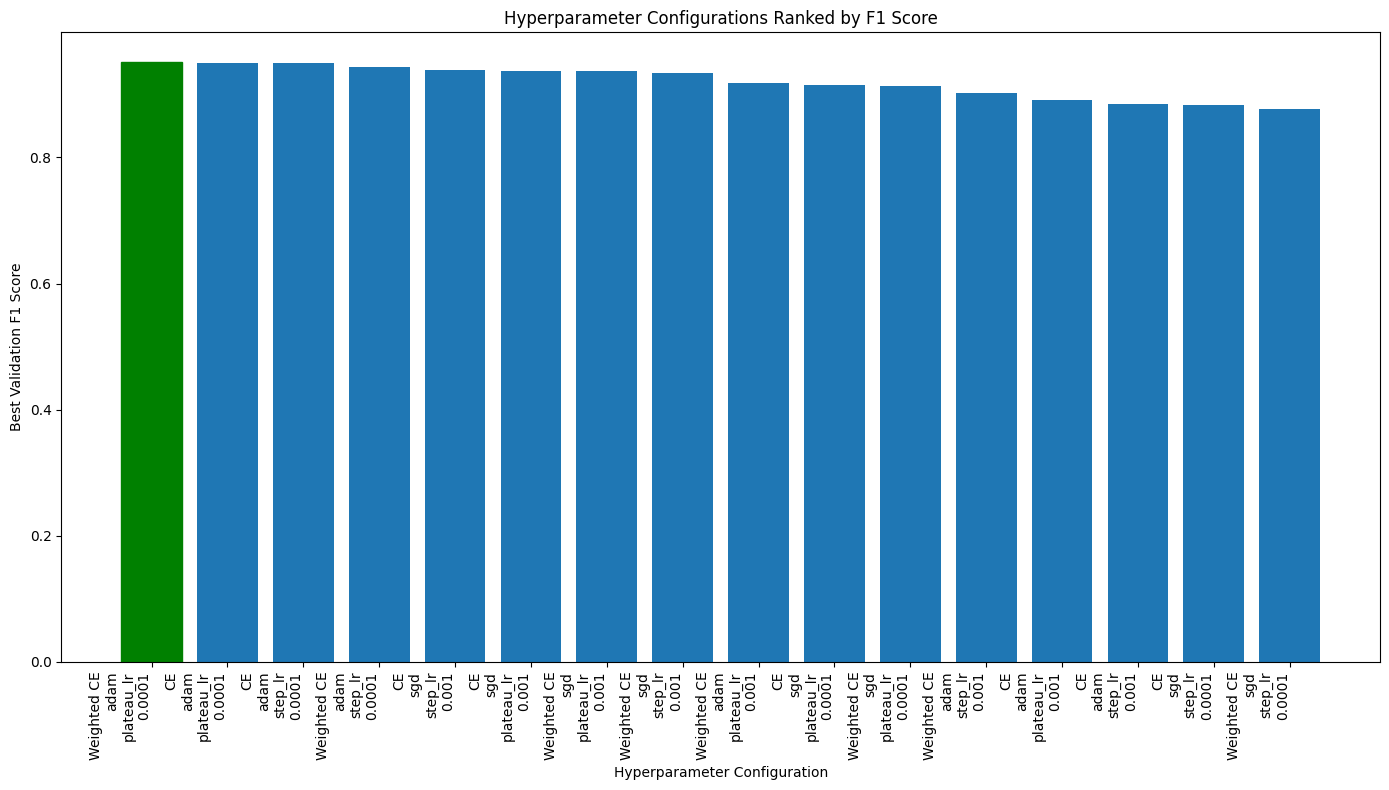

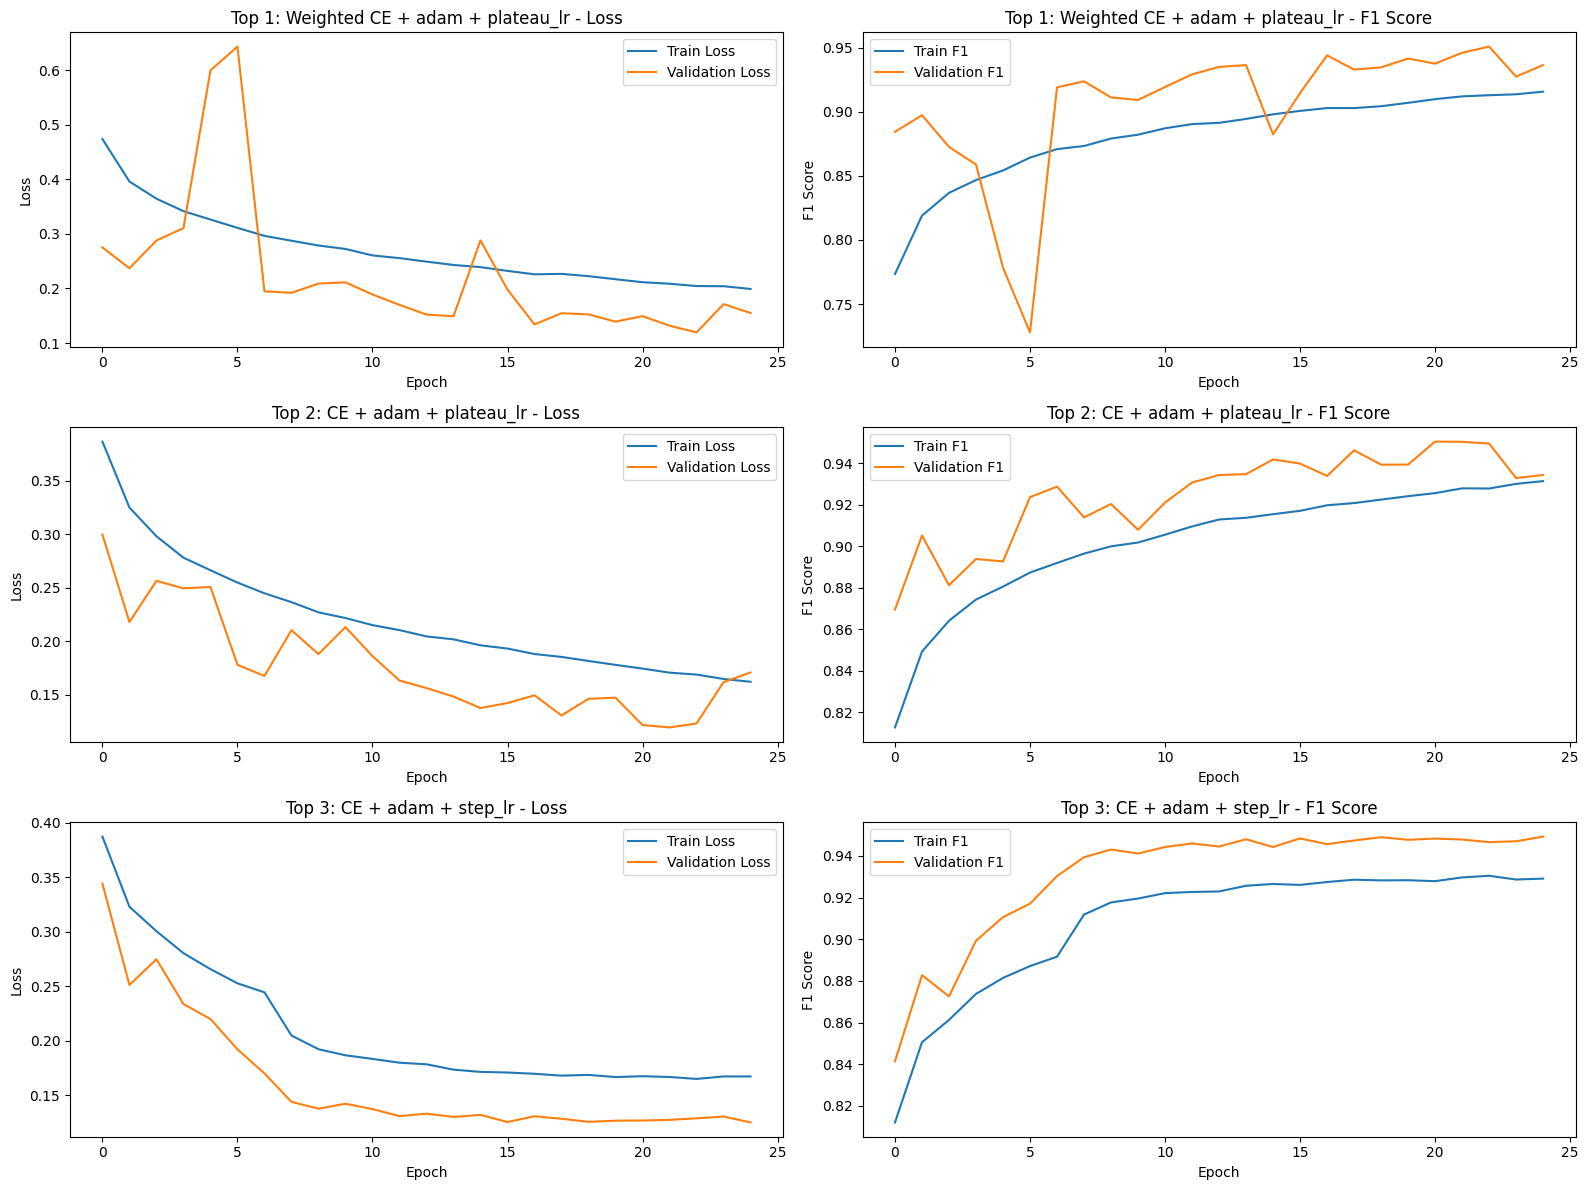

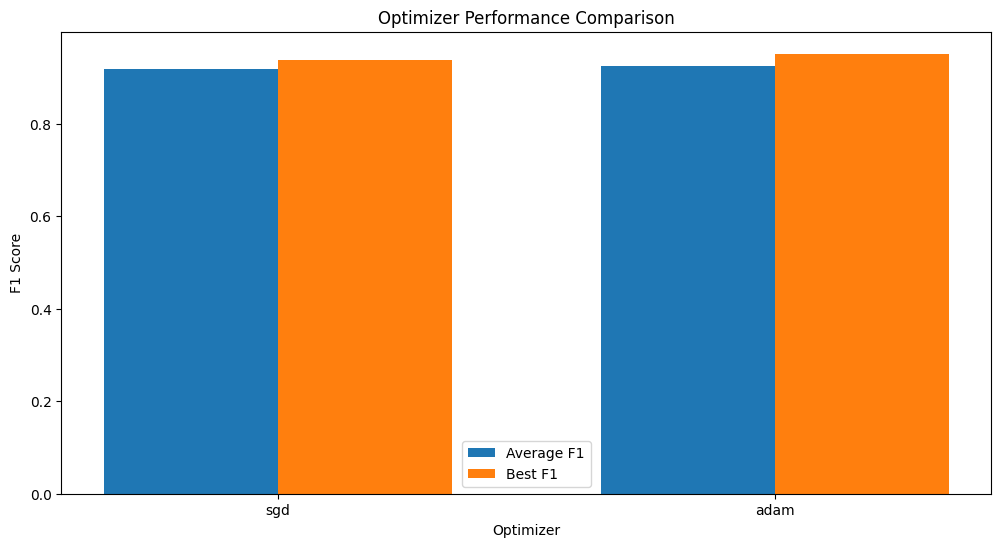

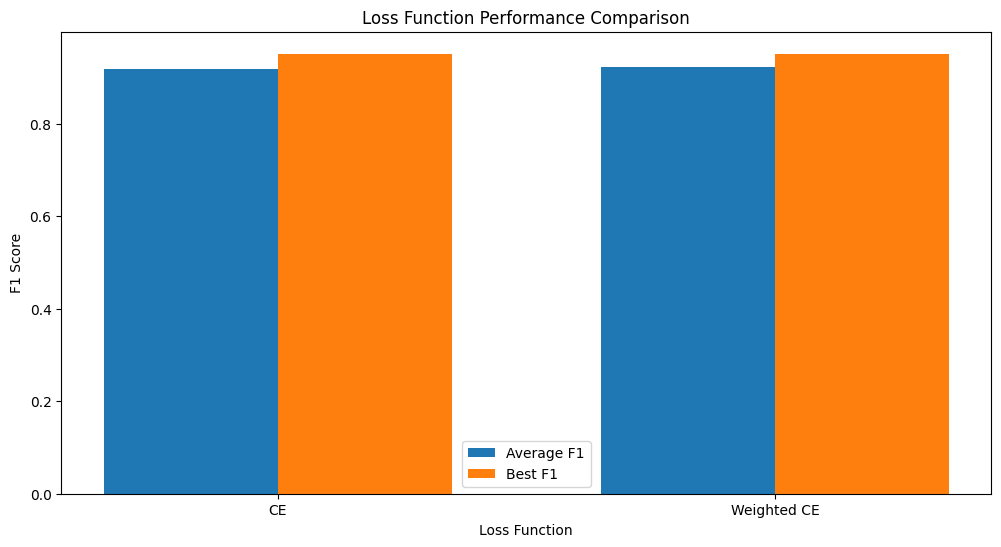

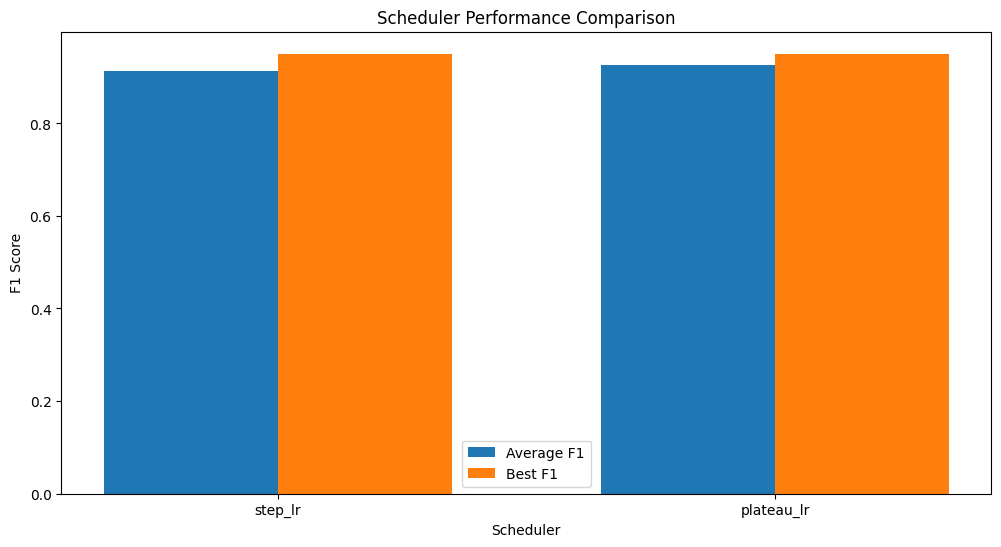

In [181]:
# Plot the results
for model_name, results in plot_results.items():
    print(model_name)
    plot_hyperparameter_results(results, model_name)

In [183]:
test_results = test_model(final_model, dataloaders["augmentation"]["resnet"]["test"])
print(f"Best Model: {final_model_params}")
print(f" - Best Validation F1: {final_model_val_f1:.4f}")
print(f" - Test Accuracy: {test_results['acc']:.4f}")
print(f" - Test F1 Score: {test_results['f1_score']:.4f}")

Test Accuracy: 0.9524, Test F1 Score: 0.9527
Best Model: {'lr': 0.0001, 'criterion': 'Weighted CE', 'optimizer': 'adam', 'scheduler': 'plateau_lr'}
 - Best Validation F1: 0.9509
 - Test Accuracy: 0.9524
 - Test F1 Score: 0.9527


In [12]:
model_efficient_net_ft = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)

# Freeze feature extractor layers (transfer learning)
freeze_layers = False  # Set to True if you only want to train the classifier

if freeze_layers:
    for param in model_efficient_net_ft.features.parameters():
        param.requires_grad = False

# Get the number of input features for the classifier layer
num_ftrs = model_efficient_net_ft.classifier[1].in_features

# Replace the classifier layer with a new one that has 2 output features (for binary classification)
model_efficient_net_ft.classifier[1] = nn.Linear(num_ftrs, 2)

# Move model to the appropriate device (GPU if available, otherwise CPU)
model_efficient_net_ft = model_efficient_net_ft.to(device)

# Define the loss function (CrossEntropyLoss for classification)
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer_efficient_net_ft = optim.Adam(model_efficient_net_ft.parameters(), lr=0.0001)

# Define a learning rate scheduler that decays the learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_efficient_net_ft, step_size=7, gamma=0.1)

In [13]:
model_efficient_net_ft, epoch_results_efficient_net = train_model(
    model_efficient_net_ft, dataloaders["augmentation"]["efficient_net"], criterion, optimizer_efficient_net_ft, exp_lr_scheduler, num_epochs=15
)

Epoch 0/14
----------
train Loss: 0.2001 Acc: 0.9187 F1: 0.9178
val Loss: 0.0974 Acc: 0.9593 F1: 0.9586

Epoch 1/14
----------
train Loss: 0.1230 Acc: 0.9521 F1: 0.9520
val Loss: 0.0638 Acc: 0.9744 F1: 0.9743

Epoch 2/14
----------
train Loss: 0.1036 Acc: 0.9589 F1: 0.9588
val Loss: 0.0574 Acc: 0.9771 F1: 0.9770

Epoch 3/14
----------
train Loss: 0.0884 Acc: 0.9655 F1: 0.9654
val Loss: 0.0546 Acc: 0.9796 F1: 0.9796

Epoch 4/14
----------
train Loss: 0.0806 Acc: 0.9691 F1: 0.9690
val Loss: 0.0519 Acc: 0.9795 F1: 0.9795

Epoch 5/14
----------
train Loss: 0.0749 Acc: 0.9709 F1: 0.9708
val Loss: 0.0512 Acc: 0.9792 F1: 0.9792

Epoch 6/14
----------
train Loss: 0.0699 Acc: 0.9741 F1: 0.9740
val Loss: 0.0354 Acc: 0.9852 F1: 0.9852

Epoch 7/14
----------
train Loss: 0.0465 Acc: 0.9823 F1: 0.9822
val Loss: 0.0286 Acc: 0.9881 F1: 0.9881

Epoch 8/14
----------
train Loss: 0.0390 Acc: 0.9850 F1: 0.9849
val Loss: 0.0282 Acc: 0.9881 F1: 0.9881

Epoch 9/14
----------
train Loss: 0.0363 Acc: 0.9865 F1

In [17]:
model_efficient_net_ft_v2 = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)

# Freeze feature extractor layers (transfer learning)
freeze_layers = False  # Set to True if you only want to train the classifier

if freeze_layers:
    for param in model_efficient_net_ft_v2.features.parameters():
        param.requires_grad = False

# Get the number of input features for the classifier layer
num_ftrs = model_efficient_net_ft_v2.classifier[1].in_features

# Replace the classifier layer with a new one that has 2 output features (for binary classification)
model_efficient_net_ft_v2.classifier[1] = nn.Linear(num_ftrs, 2)

# Move model to the appropriate device (GPU if available, otherwise CPU)
model_efficient_net_ft_v2 = model_efficient_net_ft_v2.to(device)

# Define the loss function (CrossEntropyLoss for classification)
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer_efficient_net_ft_v2 = optim.Adam(model_efficient_net_ft_v2.parameters(), lr=0.0001)

# Define a learning rate scheduler that decays the learning rate by a factor of 0.1 every 7 epochs
plateau_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_efficient_net_ft_v2, mode='min', factor=0.1, patience=7)

In [18]:
model_efficient_net_ft_v2, epoch_results_efficient_net_v2 = train_model(
    model_efficient_net_ft_v2, dataloaders["augmentation"]["efficient_net"], criterion, optimizer_efficient_net_ft_v2, plateau_lr_scheduler, num_epochs=25
)

Epoch 0/24
----------
train Loss: 0.1997 Acc: 0.9177 F1: 0.9168
val Loss: 0.0854 Acc: 0.9662 F1: 0.9663

Epoch 1/24
----------
train Loss: 0.1221 Acc: 0.9532 F1: 0.9530
val Loss: 0.0624 Acc: 0.9759 F1: 0.9759

Epoch 2/24
----------
train Loss: 0.1023 Acc: 0.9604 F1: 0.9603
val Loss: 0.0541 Acc: 0.9791 F1: 0.9789

Epoch 3/24
----------
train Loss: 0.0868 Acc: 0.9667 F1: 0.9666
val Loss: 0.0545 Acc: 0.9782 F1: 0.9781

Epoch 4/24
----------
train Loss: 0.0803 Acc: 0.9692 F1: 0.9692
val Loss: 0.0429 Acc: 0.9821 F1: 0.9820

Epoch 5/24
----------
train Loss: 0.0745 Acc: 0.9716 F1: 0.9715
val Loss: 0.0299 Acc: 0.9890 F1: 0.9890

Epoch 6/24
----------
train Loss: 0.0701 Acc: 0.9730 F1: 0.9729
val Loss: 0.0427 Acc: 0.9836 F1: 0.9835

Epoch 7/24
----------
train Loss: 0.0649 Acc: 0.9756 F1: 0.9756
val Loss: 0.0426 Acc: 0.9843 F1: 0.9842

Epoch 8/24
----------
train Loss: 0.0629 Acc: 0.9762 F1: 0.9762
val Loss: 0.0500 Acc: 0.9817 F1: 0.9815

Epoch 9/24
----------
train Loss: 0.0594 Acc: 0.9778 F1

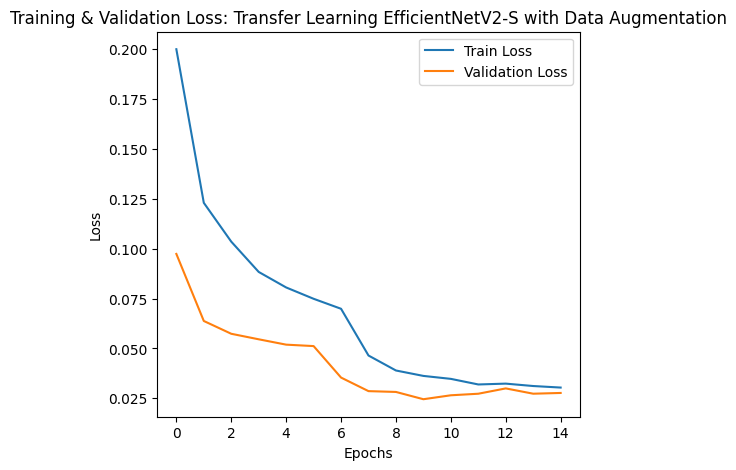

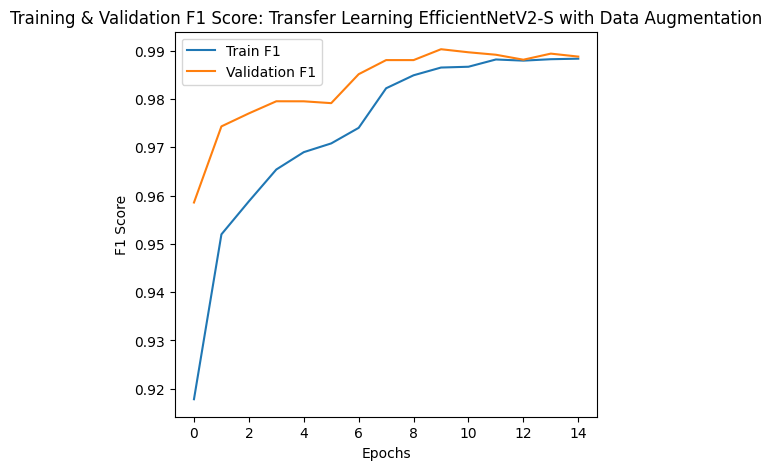

In [16]:
plot_training_history(epoch_results_efficient_net, "Transfer Learning EfficientNetV2-S with Data Augmentation")

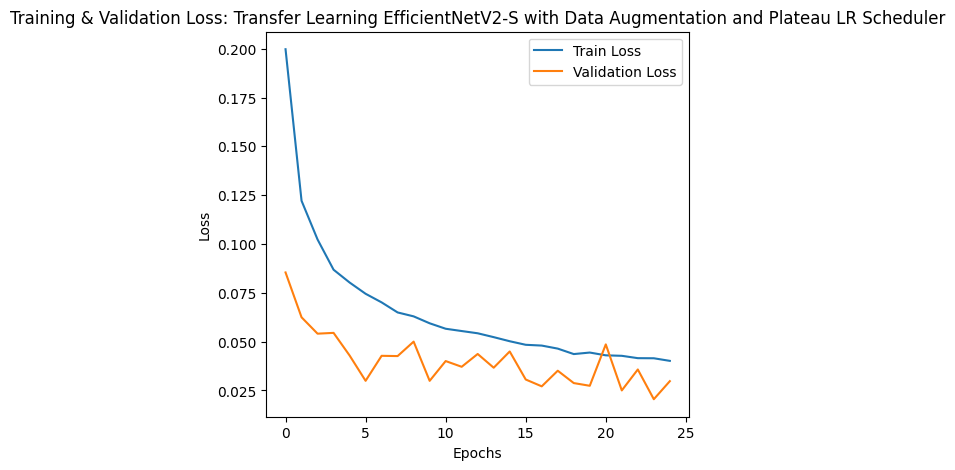

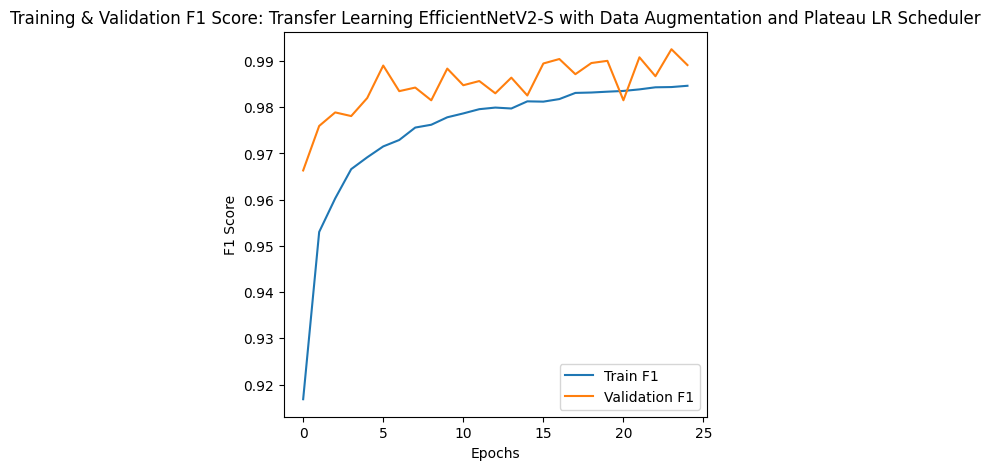

In [19]:
plot_training_history(epoch_results_efficient_net_v2, "Transfer Learning EfficientNetV2-S with Data Augmentation and Plateau LR Scheduler")

In [ ]:
model_vit_ft = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)

# Freeze feature extractor layers (transfer learning)
freeze_layers = False  # Set to True if you only want to train the classifier

if freeze_layers:
    for param in model_vit_ft.parameters():
        param.requires_grad = False

# Get the number of input features for the classifier layer
num_ftrs = model_vit_ft.heads.head.in_features

# Replace the classifier layer with a new one that has 2 output features (for binary classification)
model_vit_ft.heads.head = nn.Linear(num_ftrs, 2)

# Move model to the appropriate device (GPU if available, otherwise CPU)
model_vit_ft = model_vit_ft.to(device)

# Define the loss function (CrossEntropyLoss for classification)
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer_vit_ft = optim.Adam(model_vit_ft.parameters(), lr=0.0001)

# Define a learning rate scheduler that decays the learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_vit_ft, step_size=7, gamma=0.1)

In [12]:
model_vit_ft, epoch_results_vit_ft = train_model(
    model_vit_ft, dataloaders["augmentation"]["vit"], criterion, optimizer_vit_ft, exp_lr_scheduler, num_epochs=15
)

Epoch 0/14
----------
train Loss: 0.4395 Acc: 0.7928 F1: 0.7680
val Loss: 0.4310 Acc: 0.8066 F1: 0.8153

Epoch 1/14
----------
train Loss: 0.3682 Acc: 0.8295 F1: 0.8184
val Loss: 0.3414 Acc: 0.8481 F1: 0.8405

Epoch 2/14
----------
train Loss: 0.3432 Acc: 0.8426 F1: 0.8342
val Loss: 0.3119 Acc: 0.8541 F1: 0.8399

Epoch 3/14
----------
train Loss: 0.3214 Acc: 0.8540 F1: 0.8478
val Loss: 0.2753 Acc: 0.8709 F1: 0.8585

Epoch 4/14
----------
train Loss: 0.3089 Acc: 0.8600 F1: 0.8542
val Loss: 0.2774 Acc: 0.8767 F1: 0.8749

Epoch 5/14
----------
train Loss: 0.2926 Acc: 0.8684 F1: 0.8638
val Loss: 0.2525 Acc: 0.8899 F1: 0.8924

Epoch 6/14
----------
train Loss: 0.2806 Acc: 0.8750 F1: 0.8712
val Loss: 0.2325 Acc: 0.8964 F1: 0.8953

Epoch 7/14
----------
train Loss: 0.2056 Acc: 0.9105 F1: 0.9093
val Loss: 0.1609 Acc: 0.9312 F1: 0.9307

Epoch 8/14
----------
train Loss: 0.1826 Acc: 0.9224 F1: 0.9215
val Loss: 0.1596 Acc: 0.9319 F1: 0.9320

Epoch 9/14
----------
train Loss: 0.1678 Acc: 0.9274 F1

In [13]:
model_vit_ft_v2 = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)

# Freeze feature extractor layers (transfer learning)
freeze_layers = False  # Set to True if you only want to train the classifier

if freeze_layers:
    for param in model_vit_ft_v2.parameters():
        param.requires_grad = False

# Get the number of input features for the classifier layer
num_ftrs = model_vit_ft_v2.heads.head.in_features

# Replace the classifier layer with a new one that has 2 output features (for binary classification)
model_vit_ft_v2.heads.head = nn.Linear(num_ftrs, 2)

# Move model to the appropriate device (GPU if available, otherwise CPU)
model_vit_ft_v2 = model_vit_ft_v2.to(device)

# Define the loss function (CrossEntropyLoss for classification)
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer_vit_ft_v2 = optim.Adam(model_vit_ft_v2.parameters(), lr=0.0001)

# Define a learning rate scheduler that decays the learning rate by a factor of 0.1 every 7 epochs
plateau_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_vit_ft_v2, mode='min', factor=0.1, patience=7)

In [14]:
model_vit_ft_v2, epoch_results_vit_ft_v2 = train_model(
    model_vit_ft_v2, dataloaders["augmentation"]["vit"], criterion, optimizer_vit_ft_v2, plateau_lr_scheduler, num_epochs=25
)

Epoch 0/24
----------
train Loss: 0.4350 Acc: 0.7942 F1: 0.7714
val Loss: 0.4007 Acc: 0.7986 F1: 0.8086

Epoch 1/24
----------
train Loss: 0.3673 Acc: 0.8304 F1: 0.8200
val Loss: 0.3131 Acc: 0.8611 F1: 0.8603

Epoch 2/24
----------
train Loss: 0.3386 Acc: 0.8447 F1: 0.8370
val Loss: 0.3147 Acc: 0.8570 F1: 0.8586

Epoch 3/24
----------
train Loss: 0.3187 Acc: 0.8556 F1: 0.8495
val Loss: 0.3110 Acc: 0.8492 F1: 0.8275

Epoch 4/24
----------
train Loss: 0.3047 Acc: 0.8619 F1: 0.8564
val Loss: 0.2437 Acc: 0.8925 F1: 0.8877

Epoch 5/24
----------
train Loss: 0.2908 Acc: 0.8682 F1: 0.8636
val Loss: 0.2420 Acc: 0.8946 F1: 0.8917

Epoch 6/24
----------
train Loss: 0.2818 Acc: 0.8744 F1: 0.8705
val Loss: 0.2479 Acc: 0.8926 F1: 0.8932

Epoch 7/24
----------
train Loss: 0.2691 Acc: 0.8800 F1: 0.8767
val Loss: 0.2241 Acc: 0.9047 F1: 0.9013

Epoch 8/24
----------
train Loss: 0.2614 Acc: 0.8849 F1: 0.8820
val Loss: 0.2248 Acc: 0.9048 F1: 0.9039

Epoch 9/24
----------
train Loss: 0.2535 Acc: 0.8871 F1

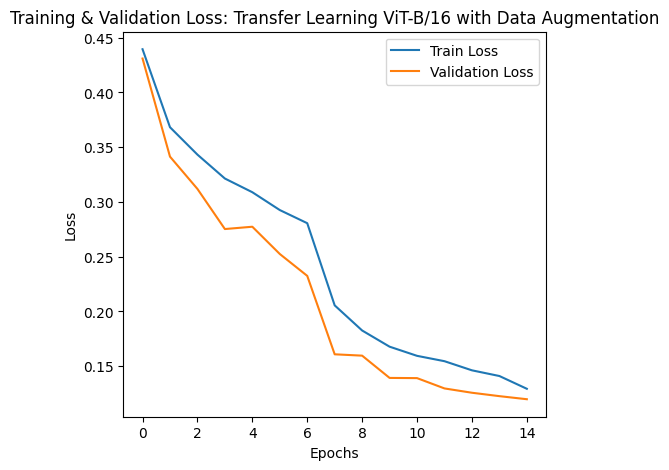

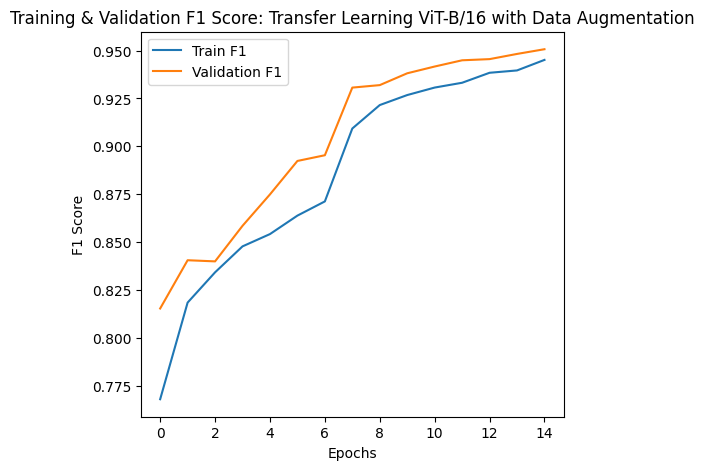

In [15]:
plot_training_history(epoch_results_vit_ft, "Transfer Learning ViT-B/16 with Data Augmentation")

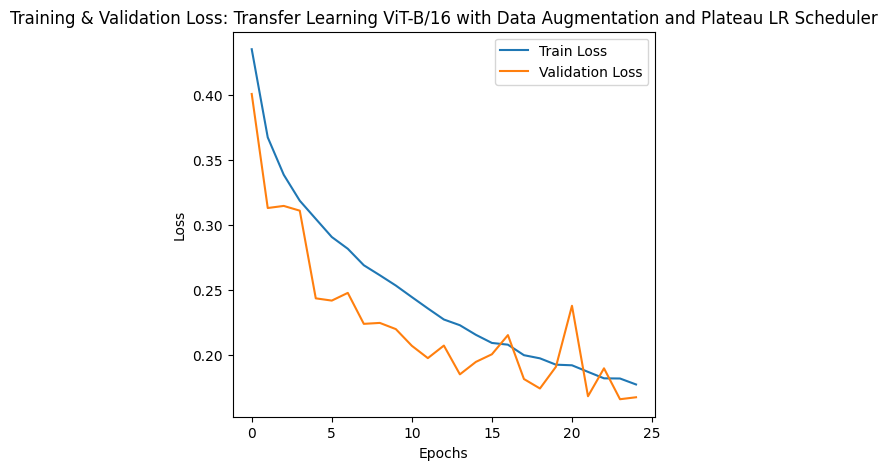

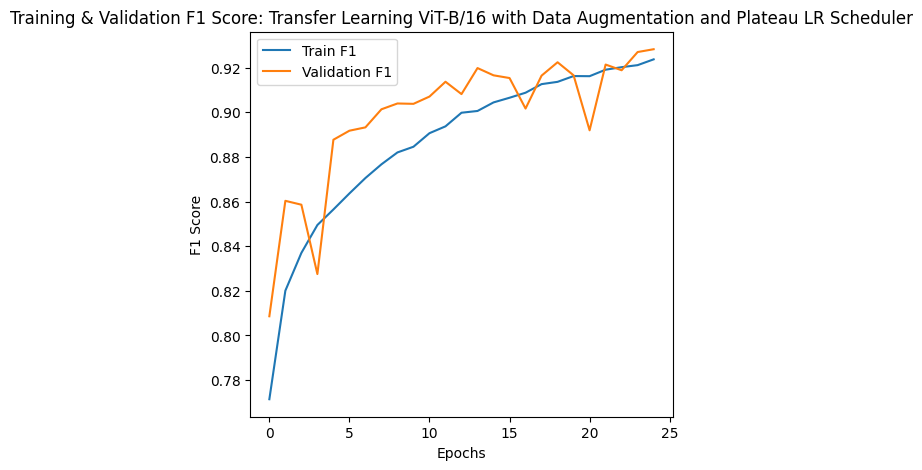

In [16]:
plot_training_history(epoch_results_vit_ft_v2, "Transfer Learning ViT-B/16 with Data Augmentation and Plateau LR Scheduler")

In [32]:
model_save_name = 'best_model.pth'
best_model_path = os.path.join("models", model_save_name)
best_model_info_path = os.path.join("models", "best_model_metadata.json")

In [33]:
best_model = model_efficient_net_ft_v2
best_model_info = {
    'model': 'efficientnet_v2_s',
    'val_f1': max(epoch_results_efficient_net_v2['val_f1']),
}

torch.save(best_model.state_dict(), best_model_path)

with open(best_model_info_path, "w") as f:
    json.dump(best_model_info, f, indent=4)

In [36]:
best_model = models.efficientnet_v2_s()
best_model.classifier[1] = nn.Linear(best_model.classifier[1].in_features, 2)

checkpoint = torch.load(best_model_path)
best_model.load_state_dict(checkpoint)
print("Loaded best model from disk")

with open(best_model_info_path, "r") as f:
    best_model_info = json.load(f)

print(f"Best model: {best_model_info['model']}")
print(f"Best validation F1: {best_model_info['val_f1']}")

Loaded best model from disk
Best model: efficientnet_v2_s
Best validation F1: 0.9925427639053584


In [38]:
best_model = best_model.to(device)

In [39]:
results = test_model(best_model, dataloaders["augmentation"]["efficient_net"]["test"])

Test Accuracy: 0.9931, Test F1 Score: 0.9930


In [40]:
test_labels = results["labels"]
test_preds = results["preds"]
conf_matrix = confusion_matrix(test_labels, test_preds)

print(classification_report(test_labels, test_preds, target_names=class_names))
print(conf_matrix)

              precision    recall  f1-score   support

        fake       0.99      1.00      1.00     13500
        real       1.00      0.98      0.99      4500

    accuracy                           0.99     18000
   macro avg       0.99      0.99      0.99     18000
weighted avg       0.99      0.99      0.99     18000

[[13479    21]
 [  104  4396]]


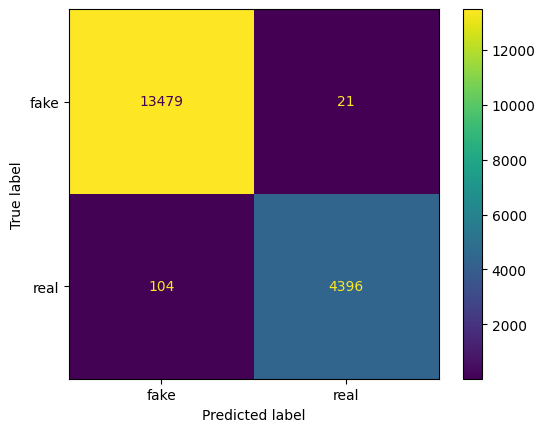

In [41]:
ConfusionMatrixDisplay(conf_matrix, display_labels=class_names).plot()
plt.show()